# Exercise 4: GNATSS Velocity Calculation

This exercise is intended to introduce the output data generated by GNATSS and how to leverage positions into estimating a velocity at a seafloor site. At the end of this exercise, you should be familiar with:

* The data format of GNATSS output and how to acces it
* How to estimate a velocity through the positions
* How to transform this velocity into a desired reference frame using an Euler Pole rotation
* How to propagate uncertainties through these operations

Throughout this exercise, we will work with the data sets collected at the GNSS-A site NCB1 offshore Coos Bay, OR, from 2018-2024 as part of the Near-trench Community Geodesy Experiment. This is the same data set as used in Exercise 2, and if you generated your own positions for these data during that exercise you can use the following code to estimate a velocity based upon your own interpretation of these data.

## Introducing the position data

The position output from any given run of GNATSS is stored in a NetCDF file `process_dataset.nc` that is stored in the output directory defined in the configuration file. This is a relatively straightforward file to ingest in python using the `xarray` and `pandas` packages. To start, let us open one of the `process_dataset.nc` files and inspect its contents. (We will also take the opportunity to declare other packages that will be used during this exercise.)

In [1]:
# Declare dependencies

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from astropy.time import Time

In [2]:
# Declare path to file
path = '../data/exercise-4/output_2024/process_dataset.nc'

# Open the file using xarray

test_ds = xr.open_dataset(path)

In [3]:
test_ds

<xarray.Dataset> Size: 1kB
Dimensions:           (transponder: 3, iteration: 3, coords: 3)
Coordinates:
  * transponder       (transponder) object 24B 'NCB1-3' 'NCB1-2' 'NCB1-1'
  * coords            (coords) object 24B 'x' 'y' 'z'
  * iteration         (iteration) int32 12B 1 2 3
Data variables:
    transponders_xyz  (iteration, transponder, coords) float64 216B ...
    delta_xyz         (iteration, transponder, coords) float64 216B ...
    sigma_xyz         (iteration, transponder, coords) float64 216B ...
    delta_enu         (iteration, transponder, coords) float64 216B ...
    sigma_enu         (iteration, transponder, coords) float64 216B ...
    transponders_lla  (iteration, transponder, coords) float64 216B ...
    rms_residual      (iteration) float64 24B ...
    error_factor      (iteration) float64 24B ...
Attributes:
    session_time:  2024-08-23T09:00:00

We can see that the data here are stored in a multi-dimensional array with key values logged for each individual transponder and iteration of the inversion. Formal definitions of the data variables are as follows:

* `transponders_xyz`: Transponder locations in a cartesian ECEF reference frame (meters)
* `delta_xyz`: Offsets from the *a priori* transponder positions in a cartesian ECEF reference frame (meters)
* `sigma_xyz`: Standard deviations of the transponder positions in a cartesian ECEF reference frame (m)
* `delta_enu`: Offsets from the *a priori* transponder positions in a local E, N, U frame (m)
* `sigma_enu`: Standard deviations of the transponder positions in a local E, N, U frame (m)
* `transponders_lla`: Transponder locations in lat, lon, height
* `rms_residual`: The RMS of the TWTT residuals (cm)
* `error_factor`: A reduced $\chi^2$ estimate of the inversion

The data we shall use for this exercise are the `delta_enu` and `sigma_enu` variables for the final iterations of the inversion, since this will allow us to directly estimate East and North velocities of the array. These values can be accessed with the following command:

In [4]:
print(test_ds.delta_enu.values,test_ds.sigma_enu.values,sep="\n\n")

[[[ 0.3018487  -0.05332573  0.71421297]
  [ 0.30184937 -0.05315313  0.71422556]
  [ 0.30201864 -0.05316931  0.71415279]]

 [[ 0.30172722 -0.05331289  0.7143391 ]
  [ 0.30172788 -0.05314026  0.71435168]
  [ 0.30189718 -0.05315648  0.71427895]]

 [[ 0.30172722 -0.05331289  0.7143391 ]
  [ 0.30172788 -0.05314026  0.71435168]
  [ 0.30189718 -0.05315648  0.71427895]]]

[[[6.05167532e-05 6.23086491e-05 4.10807226e-05]
  [6.05167563e-05 6.23084197e-05 4.10810658e-05]
  [6.05175621e-05 6.23079204e-05 4.10806361e-05]]

 [[6.04946044e-05 6.22923897e-05 4.10880804e-05]
  [6.04946076e-05 6.22921597e-05 4.10884244e-05]
  [6.04954153e-05 6.22916606e-05 4.10879918e-05]]

 [[6.04946025e-05 6.22923847e-05 4.10880815e-05]
  [6.04946056e-05 6.22921547e-05 4.10884255e-05]
  [6.04954134e-05 6.22916556e-05 4.10879929e-05]]]


The values are stored in an array of arrays, with each 3x3 subarray being the data for an iteration (later iterations are indexed later in the parent array). Within the 3x3 subarray, each row corrsponds to a different transponder and the columns correspond to East, North, and Up values, respectively. You may notice that the values for each transponder are nearly identical, which is a result of an assumption made during the positioning inversion that the GNSS-A array moves as a block (i.e. there is no strain between any pair of transponders).

## Reading xarray input from a list of files

Now that we have an idea of what the positioning data look like and how to access it, we can write a script to read it into memory for velocity estimation. In order to automate things, we have provided a file `datasets.txt` that simply lists the relative paths to each of the `process_dataset.nc` files we will use for this exercise.

Our goal in this step is to extract the average GNSS-A array ENU offset and ENU offset uncertainty for each survey. This is done by opening the `process_dataset.nc` file, reading the values stored in the last iteration of `delta_enu` and averaging them across all three transponders. The uncertainties are slightly more complicated since for proper error propagation we have to operate on the variances instead of the standard deviations. Furthermore, we shall scale the variances by the error factor in order to account for the underfitting of oceanographic signals as well as an additional factor of 750 to account for the transformation of travel time to distance (notice how this correspondes to half of the speed of ound in seawater). This isn't strictly required, but it will help us avoid underestimating our uncertainties by a significant margin.

We also need to estimate the time values associated with each individual survey. This is a little nuanced since data are collectedover a span of days. If you keep solid notes during data collection you could just guess an average date for the survey, but otherwise a pretty reliable way of estimating this is by taking the median of the time stamps logged in the `residuals.csv` file.

At the end of this step, we should have two arrays with E, N, U offsets and uncertainties for each year the transponders were surveyed.

In [5]:
# Create a list of input files

input_list = "../data/exercise-4/datasets.txt"

# Declare site information from metadata logged in the configuration file

SITE = "NCB1"

site_lat = 43.5734
site_lon = -125.1035

# Obtain list of input files
load_input = open(input_list, 'r')
input_lines = load_input.read().splitlines()
load_input.close()


In [6]:
# Open files in input list and get avg transponder offset

delta_enu = []
delta_enu_cov = []
delta_enu_sigma = []
sigma_factor = 750. # Sigma factor to scale covariances
time_decimalyear = []
j2000_reference = Time(['2000-01-01T12:00:00.0'])

for line in input_lines:
    # Read ENU positions and uncertainties
    # Open position solution file in input list
    ds_path = line + '/process_dataset.nc'
    ds = xr.open_dataset(ds_path)
    
    # Read delta ENU values and standard deviations
    all_transponder_delta_enu = ds.delta_enu.values[len(ds.delta_enu.values)-1]
    all_transponder_sigma_enu = ds.sigma_enu.values[len(ds.sigma_enu.values)-1]
    error_factor = ds.error_factor.values[len(ds.error_factor.values)-1]

    # Calculate array standard deviations and covariances
    all_transponder_cov_enu = np.multiply(all_transponder_sigma_enu,all_transponder_sigma_enu)
    array_cov_enu = [np.sum(sigma_factor*error_factor*all_transponder_cov_enu[:,0]),
                     np.sum(sigma_factor*error_factor*all_transponder_cov_enu[:,1]),
                     np.sum(sigma_factor*error_factor*all_transponder_cov_enu[:,2])]
    array_sigma_enu = [np.sqrt(array_cov_enu[0]),np.sqrt(array_cov_enu[1]),np.sqrt(array_cov_enu[2])]

    # Append offsets, covariances, and standard deviations
    delta_enu.append([np.mean(all_transponder_delta_enu[:,0]),
                      np.mean(all_transponder_delta_enu[:,1]),
                      np.mean(all_transponder_delta_enu[:,2])])
    delta_enu_cov.append(array_cov_enu)
    delta_enu_sigma.append(array_sigma_enu)

    # Derive time epoch from residuals
    # Open residual file from input list
    res_path = line + '/residuals.csv'
    residuals = pd.read_csv(res_path)

    # Calculate time from residual epochs
    time_j2000 = Time(np.mean(residuals.time) + j2000_reference.gps,format='gps')
    time_decimalyear.append(time_j2000.decimalyear)


Let's take a look at the arrays we have created here.

`time_decimalyear` is an array of the timestamps associated with each survey of the NCB1 array, with the timestamps converte into decimal years from the j2000 second timestamps logged in the `residuals.csv` files.

`delta_enu` is an array of ENU vectors that contain the offsets calculated relative to the *a priori* array position. It has units of meters.

`delta_enu_cov` and `delta_enu_sigma` are arrays of ENU vectors that contain variance and standard deviations, respectively. They are in units of meters squared and meters.

In [7]:
print(time_decimalyear, delta_enu, delta_enu_cov, delta_enu_sigma, sep="\n\n")

[array([2018.61803671]), array([2021.68838361]), array([2022.3949205]), array([2023.41376595]), array([2024.64323592])]

[[0.14265545840350294, -0.12093776046382221, -0.40997068859946345], [0.1573507277731326, -0.09674964650143948, -0.8378344784661569], [0.22852335302607027, -0.10039844406979252, -1.16520913568265], [0.27513331711606137, -0.07447391457396343, 0.08744388171915035], [0.30178409242302434, -0.053203208971178716, 0.7143232447011577]]

[[0.001254102500700082, 0.0013104560619597715, 0.0007889426626102418], [0.0002899733964149827, 0.00030642325385851126, 0.00013191586432673722], [0.00035087256225038846, 0.0003685736001929818, 0.0001645812786607218], [0.00019632432383991227, 0.00020892997265860265, 8.987927425011034e-05], [0.0002025028135781041, 0.00021471350786221274, 9.341732723629733e-05]]

[[0.03541330965470584, 0.03620022184959329, 0.028088123159268612], [0.01702860523985986, 0.01750494941033853, 0.011485463174236259], [0.018731592624504422, 0.019198270760487305, 0.0128289

## Fitting a line through positions to estimate velocity

Now that we have loaded the positions into memory, we can use them to estimate a velocity. There are a number of algorithms for this, but for the pruposes of this exercise we will use a basic weighted least squares approach. This lets us easily propagate the position uncertainties into an estimate of the velocity uncertainty. For a quick review:

The system of equations we wish to solve is

$$
A \cdot m = B,
$$

where $B$ is our data vector (positions in this case), $A$ is a matrix of equations constructed from the time records, and $m$ is the model vector of velocities we wish to solve for.

Adding a weighting matrix of uncertainties, we find

$$
A^T \cdot W \cdot A = A^T \cdot W \cdot B, \\
m = \left(A^T \cdot W \cdot A \right)^{-1} \cdot \left(A^T \cdot W \cdot B \right).
$$

An estimate of the model covariance is

$$
m_{COV} = \left(A^T \cdot W \cdot A \right)^{-1}.
$$

In [8]:

time_decimalyear = np.asarray(time_decimalyear)
length_time_series = len(time_decimalyear)

delta_enu = np.asarray(delta_enu)
delta_enu_sigma = np.asarray(delta_enu_sigma)

# Define A matrix from time epochs
right = np.tile(np.eye(3),(length_time_series,1))
left = []

for i in range(0,length_time_series):
    left.append([time_decimalyear[i]*np.eye(3)])
left = np.asarray(left)
left.shape = (3*length_time_series,3)

A = np.hstack((left,right))

# Set up loop for E, N, U dimensions
delta_enu = np.asarray(delta_enu)
delta_enu_cov = np.asarray(delta_enu_cov)

B = delta_enu
B.shape = (3*length_time_series,1)

W = delta_enu_cov
W.shape = (1,3*length_time_series)
W = np.diag(np.reciprocal(W[0]))


# Perform Weighted Least Squares inversion
# System of equations: A^T*W*A * m = A^T*W*B
# Estimate of model parameters: m = (A^T*W*A)^(-1) * (A^T*W*B)
# Estimate of model covariance: Cov = (A^T*W*A)^(-1)

# Calculate model covariances
AtW = np.matmul(A.T,W)
AtWA_inv = np.linalg.inv(np.matmul(AtW,A))

# Calculate model parameters
AtWB = np.matmul(AtW,B)
AtWA_inv_AtWB = np.matmul(AtWA_inv,AtWB)

# Save results to variables for analysis
velocity_enu = AtWA_inv_AtWB[0:3]
velocity_enu_sigma = np.sqrt(np.diag(AtWA_inv)[0:3])
velocity_corr_en = AtWA_inv[0,1]/(velocity_enu_sigma[0]*velocity_enu_sigma[1])

model_positions = np.matmul(A,AtWA_inv_AtWB)*100
model_positions.shape = (length_time_series,3)


The following code generates a rudimentary plot of the fits for each velocity component. (Note that we also plot the model for the Up component of velocity for this demonstration although these values are generally nonphysical.)

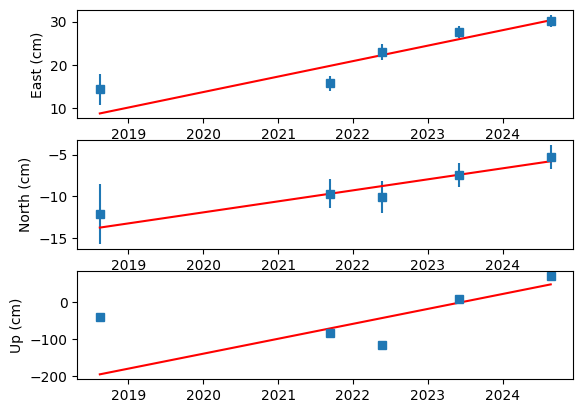

In [9]:
delta_enu.shape = (length_time_series,3)

# Convert observed positions from m to cm
observed_positions = delta_enu*100
observed_positions_sigma = delta_enu_sigma*100

plt.subplot(311)
plt.errorbar(time_decimalyear,observed_positions[:,0],yerr=observed_positions_sigma[:,0],fmt='s')
plt.plot(time_decimalyear,model_positions[:,0],'r-')
plt.ylabel("East (cm)")

plt.subplot(312)
plt.errorbar(time_decimalyear,observed_positions[:,1],yerr=observed_positions_sigma[:,1],fmt='s')
plt.plot(time_decimalyear,model_positions[:,1],'r-')
plt.ylabel("North (cm)")

plt.subplot(313)
plt.errorbar(time_decimalyear,observed_positions[:,2],yerr=observed_positions_sigma[:,2],fmt='s')
plt.plot(time_decimalyear,model_positions[:,2],'r-')
plt.ylabel("Up (cm)")

plt.show()


## Converting the velocity from ITRF to NAF using an Euler pole rotation

Believe it or not, the above is not a "useful" velocity estimate because it is in the same reference frame as the GNSS-A position estimates. For these surveys, the positions of the Wave Glider were calculated in the ITRF 2020 reference frame using PRIDE PPP-AR, and so if we wanted to calculate the velocities in a different reference frame (such as with respect to North America) we would need to perform an additional rotation. 

The following code performs the Euler pole rotation from ITRF 2020 to the North American reference frame using the pole parameters published in Table 1 of Altamimi et al. (2023).

The first step is to declare the neccessary variables for the transformation, those being the Euler pole parameters and origin rate biases.

In [10]:
# Declare radius of Earth
earth_rad = 6378000.0

# Declare Euler pole for NOAM in ITRF2020 (values given in mas/yr, convert to rad/yr)
# Values taken from Altamimi et al., (2023)
euler_pole = np.array([0.045, -0.666, -0.098])*np.pi/(180*3600*1000)
euler_pole_std = np.array([0.003, 0.003, 0.003])*np.pi/(180*3600*1000)

# Declare origin rate bias for ITRF2020 (values given in mm/yr, convert to m/yr)
# Values taken from Altamimi et al., (2023)
itrf_orb = np.array([0.37,0.35,0.74])/1000
itrf_orb_std = np.array([0.08,0.10,0.09])/1000

Next, we compute the location of the GNSS-A site on the unit sphere using the known latitude/longitude coordinates of the array center.

In [11]:
# Calculate Site location in coordinates on the unit sphere
site_lat_cos = np.cos(np.deg2rad(site_lat))
site_lat_sin = np.sin(np.deg2rad(site_lat))
site_lon_cos = np.cos(np.deg2rad(site_lon))
site_lon_sin = np.sin(np.deg2rad(site_lon))

site_unit = np.array([site_lat_cos*site_lon_cos,site_lat_cos*site_lon_sin,site_lat_sin])

Now we can calculate the velocity of the reference frame relative to North America at the location of the GNSS-A site using a cross product between the Euler pole and the site location. We then convert this to the same local ENU frame as the GNSS-A velocity we calculated earlier.

In [12]:
#Calculate site velocity from euler pole rotation

#Velocity = (Earth Radius) * (Euler Pole x Site Location) + Origin Rate Bias
site_euler_vel_xyz = earth_rad*np.cross(euler_pole,site_unit)+itrf_orb
site_euler_vel_xyz.shape = (3,1)

#Rotate to local ENU coordinates

rot_xyz_enu = np.array([[-site_lon_sin,site_lon_cos,0],
                        [-site_lat_sin*site_lon_cos,-site_lat_sin*site_lon_sin,site_lat_cos],                       
                        [site_lat_cos*site_lon_cos,site_lat_cos*site_lon_sin,site_lat_sin]])

site_euler_vel_enu = np.matmul(rot_xyz_enu,site_euler_vel_xyz)


The Euler pole is better constrained than the site velocity by a few orders of magnitude, but since it has some small uncertainty component we propagate that uncertainty as well.

In [13]:
#Propagate uncertainties for site velocity from Euler pole rotation

# Assume that the Covariance = (Partials) * (Measurement Covariance) * (Partials)^T

#Create matrix of measurement variances

measurement_uncertainties = np.array([euler_pole_std,itrf_orb_std])
measurement_uncertainties.shape = (6,1)

input_covariance = np.matmul(measurement_uncertainties,measurement_uncertainties.T)

#Create matrix of partials
vel_enu_partials = np.array([[earth_rad*(rot_xyz_enu[0,2]*site_unit[1]-rot_xyz_enu[0,1]*site_unit[2]),
                              earth_rad*(rot_xyz_enu[0,0]*site_unit[2]-rot_xyz_enu[0,2]*site_unit[0]),
                              earth_rad*(rot_xyz_enu[0,1]*site_unit[0]-rot_xyz_enu[0,0]*site_unit[1]),
                              rot_xyz_enu[0,0],rot_xyz_enu[0,1],rot_xyz_enu[0,2]],
                             [earth_rad*(rot_xyz_enu[1,2]*site_unit[1]-rot_xyz_enu[1,1]*site_unit[2]),
                              earth_rad*(rot_xyz_enu[1,0]*site_unit[2]-rot_xyz_enu[1,2]*site_unit[0]),
                              earth_rad*(rot_xyz_enu[1,1]*site_unit[0]-rot_xyz_enu[1,0]*site_unit[1]),
                              rot_xyz_enu[1,0],rot_xyz_enu[1,1],rot_xyz_enu[1,2]],
                             [earth_rad*(rot_xyz_enu[2,2]*site_unit[1]-rot_xyz_enu[2,1]*site_unit[2]),
                              earth_rad*(rot_xyz_enu[2,0]*site_unit[2]-rot_xyz_enu[2,2]*site_unit[0]),
                              earth_rad*(rot_xyz_enu[2,1]*site_unit[0]-rot_xyz_enu[2,0]*site_unit[1]),
                              rot_xyz_enu[2,0],rot_xyz_enu[2,1],rot_xyz_enu[2,2]]])

site_euler_vel_enu_cov = np.matmul(np.matmul(vel_enu_partials,input_covariance),vel_enu_partials.T)

site_euler_vel_east_std = np.sqrt(site_euler_vel_enu_cov[0,0])
site_euler_vel_north_std = np.sqrt(site_euler_vel_enu_cov[1,1])
site_euler_vel_corr_en = site_euler_vel_enu_cov[0,1]/(site_euler_vel_east_std*site_euler_vel_north_std)


Finally, we can combine the velocity and uncertainty from the GNSS-A and the Euler pole rotation to estimate our final velocity with respect to North America.

In [14]:
#Add velocity from least squares fit and euler Pole rotation

velocity_output = (velocity_enu-site_euler_vel_enu)*100
velocity_output_std = 100*np.array([np.sqrt(site_euler_vel_enu_cov[0,0]+velocity_enu_sigma[0]*velocity_enu_sigma[0]),
                                    np.sqrt(site_euler_vel_enu_cov[1,1]+velocity_enu_sigma[1]*velocity_enu_sigma[1])])
velocity_output_corr = (velocity_enu_sigma[0]*velocity_enu_sigma[1]*velocity_corr_en+site_euler_vel_east_std*site_euler_vel_north_std*site_euler_vel_corr_en)/(np.sqrt(site_euler_vel_enu_cov[0,0]+velocity_enu_sigma[0]*velocity_enu_sigma[0])+np.sqrt(site_euler_vel_enu_cov[1,1]+velocity_enu_sigma[1]*velocity_enu_sigma[1]))

output = [site_lon,
          site_lat,
          velocity_output[0,0],
          velocity_output[1,0],
          velocity_output_std[0],
          velocity_output_std[1],
          velocity_output_corr]
output = np.asarray(output)
output.shape = (1,7)

In [15]:
print(" The East velocity is ",str.format('{0:.3f}',velocity_output[0,0]),
      " +\-",str.format('{0:.3f}',velocity_output_std[0]),"cm/yr.\n",
      "The North velocity is ",str.format('{0:.3f}',velocity_output[1,0]),
      " +\-",str.format('{0:.3f}',velocity_output_std[1]),"cm/yr.")

 The East velocity is  4.897  +\- 0.524 cm/yr.
 The North velocity is  2.532  +\- 0.537 cm/yr.


## References

 * Altamimi, Z., Métivier, L., Rebischung, P., Collilieux, X., Chanard, K., & Barnéoud, J. (2023). ITRF2020 plate motion model. Geophysical Research Letters, 50, e2023GL106373. https://doi.org/10.1029/2023GL106373 